In [461]:
import os
import csv
from functools import partial
import glob

from scipy.io import loadmat
import scipy
import ruptures as rpt
from hampel import hampel
import pandas as pd


import numpy as np 

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import matplotlib.mlab as mlab

import seaborn as sns

In [464]:
noisy_mats  = glob.glob('../../../datasets/Data_27012021_noisy/real/*.mat')
noisy_mats.sort()

print (noisy_mats)

['../../../datasets/Data_27012021_noisy/real/OFVC4kW_LM10Hz_paliers_0to120PercTnom_Data.mat', '../../../datasets/Data_27012021_noisy/real/OFVC4kW_LM20Hz_TorqueSteps_20190419_Data.mat', '../../../datasets/Data_27012021_noisy/real/OFVC4kW_LM30Hz_paliers_0to120PercTnom_Data.mat', '../../../datasets/Data_27012021_noisy/real/OFVC4kW_LM45Hz_TorqueSteps_20190419_Data.mat', '../../../datasets/Data_27012021_noisy/real/OFVC4kW_LM50Hz_paliers_0to120PercTnom_Data.mat', '../../../datasets/Data_27012021_noisy/real/OFVC4kW_LM60Hz_TorqueSteps_20190419_Data.mat', '../../../datasets/Data_27012021_noisy/real/OFVC4kW_LM68Hz_paliers_0to120PercTnom_Data.mat', '../../../datasets/Data_27012021_noisy/real/OFVC4kW_NoLM_SpeedVariations2_20190419_Data.mat', '../../../datasets/Data_27012021_noisy/real/OFVC4kW_NoLM_SpeedVariations_20190419_Data.mat', '../../../datasets/Data_27012021_noisy/real/OFVC4kW_NoLM_paliers_0to100Hz_Data.mat']


In [498]:
current_d = []
current_q = []
voltage_d = []
voltage_q = []
speed = []
torque = []


def get_noise(signal, locs, thr=2):
    noise = []

    for loc in locs:
        part = np.copy(signal[int(loc[0]): int(loc[1])])
        part = np.delete(part, np.where(part < part[0] - thr))
        part = np.delete(part, np.where(part > part[0] + thr))
        mean = np.mean(part)
        noise += list(part - mean)
  
    return noise

def get_stats(path): 
    data = loadmat(path)
    mask = np.zeros(data['time'].shape[1])
    
    speed_r = csv.reader(open(path.replace('.mat', '_speed.csv'), 'r'), delimiter='\t')
    for row in speed_r:
        mask[int(row[0]):int(row[1])] = 1
        
    torque_r = csv.reader(open(path.replace('.mat', '_torque.csv'), 'r'), delimiter='\t')
    for row in torque_r:
        mask[int(row[0]):int(row[1])] = 1
    
    segs = []
    pair = []
    enter = False
    for i in range(0, mask.shape[0]):
        if mask[i] == 0 and not enter:
            enter = True
            pair.append(i)
        if mask[i] == 1 and enter:
            enter = False
            pair.append(i-1)
            segs.append(pair)
            pair = []
            
    return segs, mask
        
for mat_file in noisy_mats:
# mat_file = noisy_mats[2]
    noisy_mat = loadmat(mat_file)
    segs, mask = get_stats(mat_file)

    current_d += get_noise(noisy_mat['noisy_current_d'][0], segs, 0.5)
    current_q += get_noise(noisy_mat['noisy_current_q'][0], segs, 1)
    voltage_d += get_noise(noisy_mat['noisy_voltage_d'][0], segs, 5)
    voltage_q += get_noise(noisy_mat['noisy_voltage_q'][0], segs, 5)
#     speed += get_noise(noisy_mat['noisy_speed'][0], segs, 5)
#     torque += get_noise(noisy_mat['noisy_speed'][0], segs, 10)


current_d = np.asarray(current_d)
current_q = np.asarray(current_q)
voltage_d = np.asarray(voltage_d)
voltage_q = np.asarray(voltage_q)
# speed = np.asarray(speed)
# torque = np.asarray(torque)


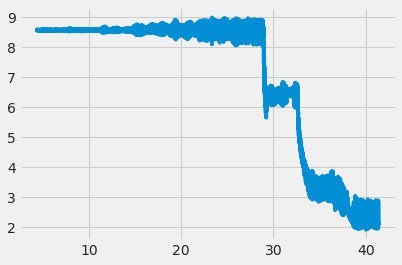

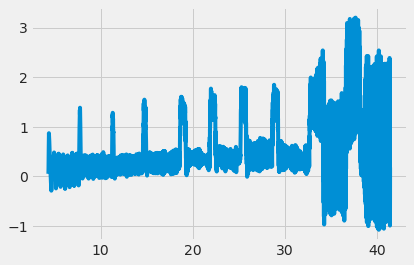

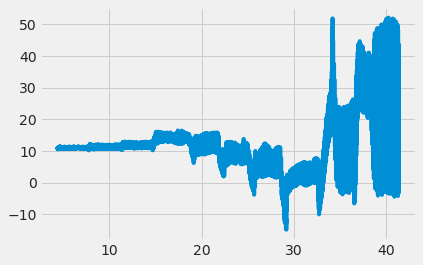

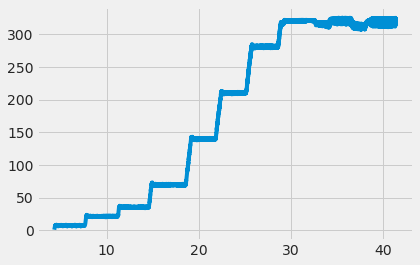

In [499]:
noisy_mat = loadmat(noisy_mats[9])
plt.plot(noisy_mat['time'][0], noisy_mat['noisy_current_d'][0])
plt.show()
plt.plot(noisy_mat['time'][0], noisy_mat['noisy_current_q'][0])
plt.show()
plt.plot(noisy_mat['time'][0], noisy_mat['noisy_voltage_d'][0])
plt.show()
plt.plot(noisy_mat['time'][0], noisy_mat['noisy_voltage_q'][0])
plt.show()

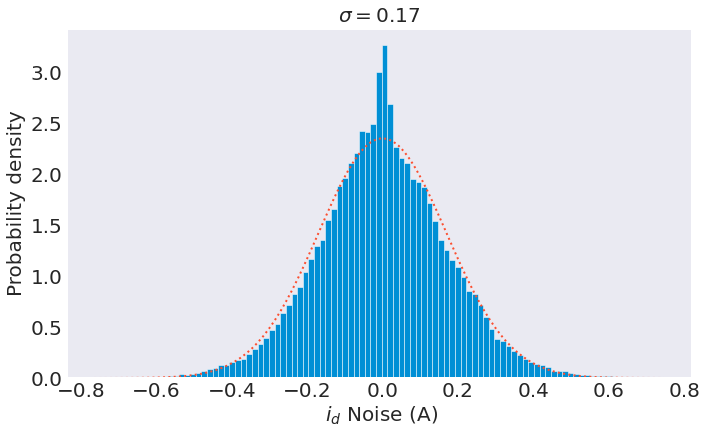

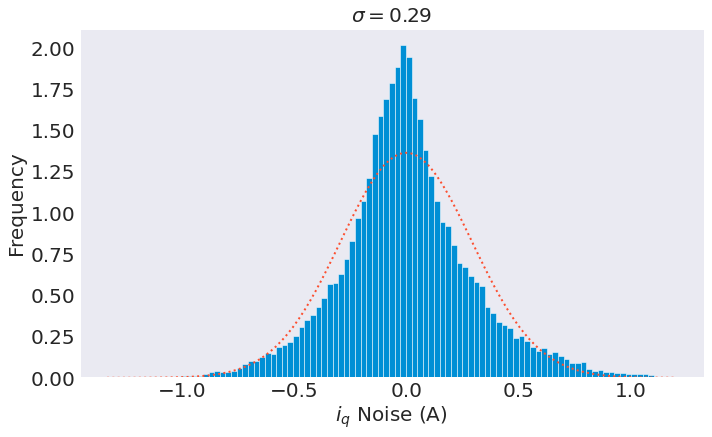

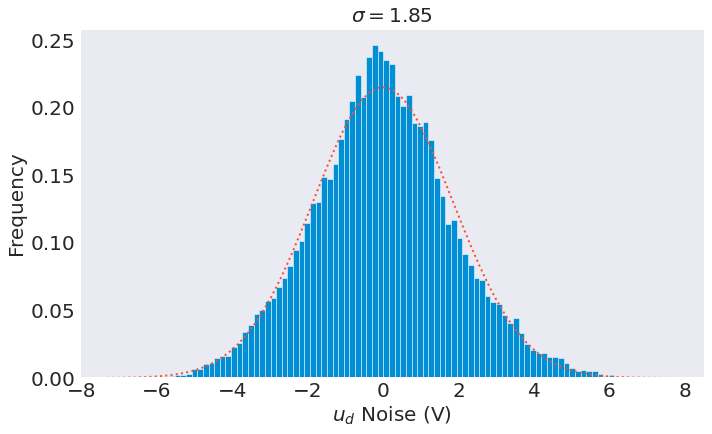

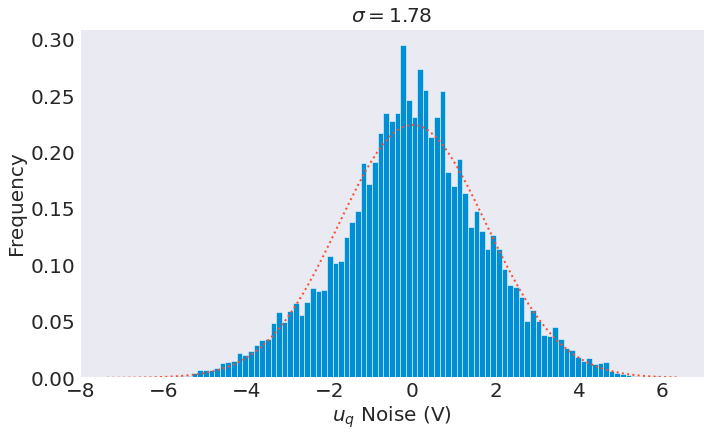

In [521]:
def to_percent(y, position, n):
    s = str(int(round(100 * y / n, 0)))

    if matplotlib.rcParams['text.usetex']:
        return s + r'$\%$'

    return s + '%'

bins = 101
sns.set_style("dark")
fig, ax = plt.subplots(figsize=(10,6))
_, xbins, _ = ax.hist(current_d, bins=bins, rwidth=1, density=True)

mu, sigma = scipy.stats.norm.fit(current_d)
best_fit_line = scipy.stats.norm.pdf(xbins, mu, sigma)
plt.plot(xbins, best_fit_line, ':', linewidth=2)


# percent_formatter = partial(to_percent,
#                                 n=len(current_d))
# formatter = FuncFormatter(percent_formatter)
# plt.gca().yaxis.set_major_formatter(formatter)
plt.ylabel('Probability density', fontsize=20)
plt.xlabel(r' $i_d$ Noise (A)', fontsize=20)
plt.title(f'$\sigma={round(sigma, 2)}$')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('current_d_noise_stat.pdf', bbox_inches="tight", dpi=300)

sns.set_style("dark")
fig, ax = plt.subplots(figsize=(10,6))
_, xbins, _ = ax.hist(current_q, bins=bins, rwidth=1, density=True)

mu, sigma = scipy.stats.norm.fit(current_q)
best_fit_line = scipy.stats.norm.pdf(xbins, mu, sigma)
plt.plot(xbins, best_fit_line, ':', linewidth=2)
# percent_formatter = partial(to_percent,
#                                 n=len(current_q))
# formatter = FuncFormatter(percent_formatter)
# plt.gca().yaxis.set_major_formatter(formatter)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel(r'$i_q$ Noise (A)', fontsize=20)
plt.title(f'$\sigma={round(sigma, 2)}$')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('current_q_noise_stat.pdf', bbox_inches="tight", dpi=300)

sns.set_style("dark")
fig, ax = plt.subplots(figsize=(10,6))
_, xbins, _ = ax.hist(voltage_d, bins=bins, rwidth=1, density=True)

mu, sigma = scipy.stats.norm.fit(voltage_d)
best_fit_line = scipy.stats.norm.pdf(xbins, mu, sigma)
plt.plot(xbins, best_fit_line, ':', linewidth=2)
# percent_formatter = partial(to_percent,
#                                 n=len(voltage_d))
# formatter = FuncFormatter(percent_formatter)
# plt.gca().yaxis.set_major_formatter(formatter)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel(r'$u_d$ Noise (V)', fontsize=20)
plt.title(f'$\sigma={round(sigma, 2)}$')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('voltage_d_noise_stat.pdf', bbox_inches="tight", dpi=300)

sns.set_style("dark")
fig, ax = plt.subplots(figsize=(10,6))
_, xbins, _ = ax.hist(voltage_q, bins=bins, rwidth=1, density=True)

mu, sigma = scipy.stats.norm.fit(voltage_q)
best_fit_line = scipy.stats.norm.pdf(xbins, mu, sigma)
ax.plot(xbins, best_fit_line, ':', linewidth=2)
# percent_formatter = partial(to_percent,
#                                 n=len(voltage_q))
# formatter = FuncFormatter(percent_formatter)
# plt.gca().yaxis.set_major_formatter(formatter)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel(r'$u_q$ Noise (V)', fontsize=20)
plt.title(f'$\sigma={round(sigma, 2)}$')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('voltage_q_noise_stat.pdf', bbox_inches="tight", dpi=300)